# Utilisation du modèle de language camemBERT et sentenceTranformer pour la détection des valeurs quasi-correspondantes entre deux listes de str

## Modèle camemERT

In [1]:
from transformers import CamembertModel, CamembertTokenizer
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd

In [2]:
# Charger le modèle CamemBERT et le tokenizer
### Le modèle est pré-entrainé
model_name = "camembert-base"
tokenizer = CamembertTokenizer.from_pretrained(model_name)
model = CamembertModel.from_pretrained(model_name)

# Calculs des embeddings de CamemBERT pour chaque entité de liste
def get_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Obtenir la sortie du dernier "état caché" :
    embeddings = outputs.last_hidden_state
    # Moyenne des embeddings sur les tokens pour obtenir un vecteur fixe de 768 dimensions :
    sentence_embedding = torch.mean(embeddings, dim=1).squeeze()
    return sentence_embedding.numpy()




C:\Users\Lucas\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## récupération datas

In [3]:
from expreseau_gtfs.feed import gtfs_feed # librairie perso

# fonctions calculs de scores pour la ressemblance entre deux str :
def calcul_scores_levenshtein(liste_strings, string_reference):
    scores = []
    for string in liste_strings:
        score = 1 - Levenshtein.distance(string, string_reference) / max(len(string), len(string_reference))
        scores.append(score)
    return scores
    
def calcul_scores_jaccard(liste_strings, string_reference):
    scores = []
    for string in liste_strings:
        ensemble1 = set(string)
        ensemble2 = set(string_reference)
        score = len(ensemble1.intersection(ensemble2)) / len(ensemble1.union(ensemble2))
        scores.append(score)
    return scores
    
def nom_arret_plus_proche(liste_strings, string_reference, methode = "levenshtein"):
    if methode == "levenshtein":
        scores = calcul_scores_levenshtein(liste_strings, string_reference)
    if methode == "jaccard":
        scores = calcul_scores_jaccard(liste_strings, string_reference)
        
    return liste_strings[scores.index(max(scores))]

# on charge les fichiers gtfs
feed_ter = gtfs_feed(gtfs_path = r"C:\Users\Lucas\Documents\2_DONNEES\GTFS\SNCF\TER_NATIONAL_2024.zip",
                     date="20240905",
                     plage_horaire=[0,25])

datas_gtfs = feed_ter.routes[['route_id', "route_long_name", "route_short_name"]]\
        .merge(feed_ter.trips[['route_id', "trip_id", "direction_id"]])\
        .merge(feed_ter.stop_times[['trip_id', "stop_sequence", "stop_id"]])
# on fusionne avec les arrets :
datas_gtfs = datas_gtfs.merge(feed_ter.stops[["stop_id", "stop_name"]])

#### NETTOYAGE DES NOMS LONGS DES ROUTES :
liste_routes = list()
for route in feed_ter.routes.route_long_name.values.tolist():
    liste_temp = list()
    
    tmp = datas_gtfs[datas_gtfs.route_long_name == route]
    # if route == 'Grenoble - Chambery': print(tmp.stop_name.unique())
    
    if tmp.empty:
        liste_routes.append(['ligne introuvable'])
        continue
    # print(route.split(' - '))
    for arret in route.split(' - '):
        # print(arret)
        liste_temp.append(nom_arret_plus_proche(tmp.stop_name.values, arret, methode="jaccard"))
        

    l = ""
    for x in liste_temp:
        if liste_temp[liste_temp.index(x)] != liste_temp[-1]: 
            l += x + ' - '
        else:
            l += x
    liste_routes.append(l)
# On créé un df des routes avec le nom cleané et on fusionne avec le df datas_gtfs :
routes = feed_ter.routes[["route_id", "route_long_name"]]
routes["route_long_name_c"] = liste_routes
datas_gtfs = datas_gtfs.merge(routes)
datas_gtfs.head()


,route_id,route_long_name,route_short_name,trip_id,direction_id,stop_sequence,stop_id,stop_name,route_long_name_c
0,FR:Line::00F2577A-6A87-42E0-95F3-07351E4BC2F6:,Bening - Sarreguemines,P53,OCESN35042R3450155:2024-09-04T00:27:05Z,0.0,0,StopPoint:OCECar TER-87737676,Sarreguemines Collège Himmelsberg,Metzing Centre - Sarreguemines
1,FR:Line::00F2577A-6A87-42E0-95F3-07351E4BC2F6:,Bening - Sarreguemines,P53,OCESN35042R3450155:2024-09-04T00:27:05Z,0.0,1,StopPoint:OCECar TER-87193565,Ippling Rue de Sarreguemines,Metzing Centre - Sarreguemines
2,FR:Line::00F2577A-6A87-42E0-95F3-07351E4BC2F6:,Bening - Sarreguemines,P53,OCESN35042R3450155:2024-09-04T00:27:05Z,0.0,2,StopPoint:OCECar TER-87737718,Hundling Stade,Metzing Centre - Sarreguemines
3,FR:Line::00F2577A-6A87-42E0-95F3-07351E4BC2F6:,Bening - Sarreguemines,P53,OCESN35044R3450689:2024-09-04T00:27:05Z,0.0,0,StopPoint:OCECar TER-87737676,Sarreguemines Collège Himmelsberg,Metzing Centre - Sarreguemines
4,FR:Line::00F2577A-6A87-42E0-95F3-07351E4BC2F6:,Bening - Sarreguemines,P53,OCESN35044R3450689:2024-09-04T00:27:05Z,0.0,1,StopPoint:OCECar TER-87737692,Sarreguemines Lycée Pange,Metzing Centre - Sarreguemines


In [4]:
# on charge les fichiers de lignes à comparer :
fic = r"C:/Users/Lucas/Documents/0_NOTEBOOKS/DECARBONATION/TER - CDL 2022_LS (version 1)_LF.csv"
lignes = pd.read_csv(fic, sep = ";", encoding = "iso-8859-1")[['lignes']]
lignes["lignes_c"] = [str(x).replace(f"{str(x).split(' - ')[0]} - ", "") for x in lignes.lignes.values]
lignes['lignes_c'] = lignes.lignes_c.replace('RE ', '')
lignes

,lignes,lignes_c
0,C1 - Grenoble - Chambery,Grenoble - Chambery
1,C10 - Clermont-Ferrand - Thiers,Clermont-Ferrand - Thiers
2,C11 - Saint-Marcellin - Grenoble Universités G...,Saint-Marcellin - Grenoble Universités Gières
3,C12 - Lyon Perrache - Lyon Part Dieu - Roanne,Lyon Perrache - Lyon Part Dieu - Roanne
4,C13 - Annecy - St-Gervais Les Bains Le Fayet,Annecy - St-Gervais Les Bains Le Fayet
...,...,...
98,P89 - Firminy - Dunières,Firminy - Dunières
99,P91 - Albertville - Moûtiers,Albertville - Moûtiers
100,P95 - Ambert - Le Puy En Velay,Ambert - Le Puy En Velay
101,NaN,nan


### Calcul des embeddings et des matrices cosinus 

In [6]:
lignes_1 = list()
lignes_2 = list()
index_lignes_2 = list()
scores = list()
scores_jaccard = list()

# Obtenir les embeddings pour chaque phrase dans les deux listes
embeddings_theorique = [get_embedding(sentence) for sentence in datas_gtfs.route_long_name_c.unique().tolist()]
embeddings_reeles =    [get_embedding(sentence) for sentence in lignes.lignes_c.values[:-2].tolist()]

# Comparer chaque phrase de list1 avec chaque phrase de list2 en utilisant la matrice de similarité cosinus

for idx1, sentence1 in enumerate(lignes.lignes_c.values[:-2].tolist()):
    similarities = cosine_similarity([embeddings_reeles[idx1]], embeddings_theorique)[0]
    most_similar_idx = np.argmax(similarities)

    lignes_1.append(sentence1)
    lignes_2.append(datas_gtfs.route_long_name_c.unique().tolist()[most_similar_idx])
    index_lignes_2.append(most_similar_idx)
    scores.append(similarities[most_similar_idx])
    scores_jaccard.append(calcul_scores_jaccard(liste_strings=[sentence1], string_reference=datas_gtfs.route_long_name_c.unique().tolist()[most_similar_idx])[0])

In [7]:
res = pd.DataFrame(zip(lignes_1,lignes_2,index_lignes_2,scores,scores_jaccard), 
             columns=["lignes_1","lignes_2","index_lignes_2","scores","scores_jaccard"])#.sort_values(by='scores_jaccard')
res.head()

,lignes_1,lignes_2,index_lignes_2,scores,scores_jaccard
0,Grenoble - Chambery,Grenoble - Gap,389,0.931631,0.666667
1,Clermont-Ferrand - Thiers,Clermont-Ferrand - Thiers,386,1.000000,1.000000
2,Saint-Marcellin - Grenoble Universités Gières,Saint-Marcellin - Grenoble Universités - Gières,394,0.991988,1.000000
3,Lyon Perrache - Lyon Part Dieu - Roanne,Lyon Perrache - Lyon Part Dieu - Roanne,145,1.000000,1.000000
4,Annecy - St-Gervais Les Bains Le Fayet,Annecy - Saint-Gervais-les-Bains-Le Fayet,17,0.909788,0.947368


### Résultats

In [8]:
import matplotlib.pyplot as plt

In [9]:
res.scores_jaccard.describe()

count    101.000000
mean       0.611043
std        0.293030
min        0.111111
25%        0.363636
50%        0.608696
75%        0.933333
max        1.000000
Name: scores_jaccard, dtype: float64

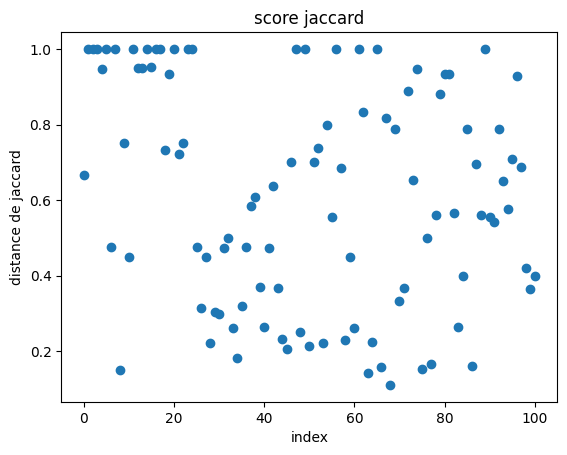

In [13]:

plt.scatter(res.index, res.scores_jaccard, s = res.scores*150, alpha = 0.5))
plt.title("score jaccard")
plt.xlabel('index')
plt.ylabel('distance de jaccard')
plt.show()

## Utilisation du modèle SentenceTransformers

In [15]:
from sentence_transformers import SentenceTransformer

In [16]:
# charge le modèle préentrainé et les embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')  # Ce modèle est léger et performant pour la similarité de phrases
# Obtenir les embeddings de SBERT pour chaque phrase
embeddings_theorique = model.encode(datas_gtfs.route_long_name_c.unique().tolist())
embeddings_reeles = model.encode(lignes.lignes_c.values[:-2].tolist())

C:\Users\Lucas\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [17]:
lignes_1 = list()
lignes_2 = list()
index_lignes_2 = list()
scores = list()
scores_jaccard = list()

for idx1, sentence1 in enumerate(lignes.lignes_c.values[:-2].tolist()):
    similarities = cosine_similarity([embeddings_reeles[idx1]], embeddings_theorique)[0]
    most_similar_idx = np.argmax(similarities)

    lignes_1.append(sentence1)
    lignes_2.append(datas_gtfs.route_long_name_c.unique().tolist()[most_similar_idx])
    index_lignes_2.append(most_similar_idx)
    scores.append(similarities[most_similar_idx])
    scores_jaccard.append(calcul_scores_jaccard(liste_strings=[sentence1], string_reference=datas_gtfs.route_long_name_c.unique().tolist()[most_similar_idx])[0])

In [18]:
res = pd.DataFrame(zip(lignes_1,lignes_2,index_lignes_2,scores,scores_jaccard), 
             columns=["lignes_1","lignes_2","index_lignes_2","scores","scores_jaccard"])#.sort_values(by='scores_jaccard')
res.head()

,lignes_1,lignes_2,index_lignes_2,scores,scores_jaccard
0,Grenoble - Chambery,Grenoble - Chambéry - Challes-les-Eaux,18,0.769946,0.736842
1,Clermont-Ferrand - Thiers,Clermont-Ferrand - Thiers,386,1.000000,1.000000
2,Saint-Marcellin - Grenoble Universités Gières,Saint-Marcellin - Grenoble Universités - Gières,394,0.995729,1.000000
3,Lyon Perrache - Lyon Part Dieu - Roanne,Lyon Perrache - Lyon Part Dieu - Roanne,145,1.000000,1.000000
4,Annecy - St-Gervais Les Bains Le Fayet,Annecy - Saint-Gervais-les-Bains-Le Fayet,17,0.919080,0.947368


In [19]:
res.scores_jaccard.describe()

count    101.000000
mean       0.669907
std        0.271161
min        0.157895
25%        0.478261
50%        0.700000
75%        0.933333
max        1.000000
Name: scores_jaccard, dtype: float64

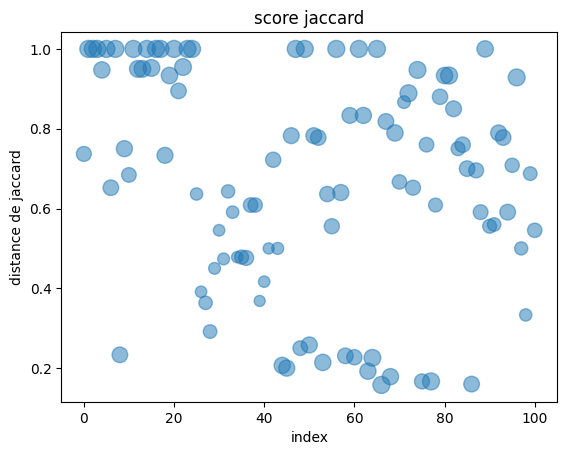

In [21]:
plt.scatter(res.index, res.scores_jaccard, s = res.scores*150, alpha = 0.5)
plt.title("score jaccard")
plt.xlabel('index')
plt.ylabel('distance de jaccard')
plt.show()

In [22]:
res.sort_values(by="scores_jaccard").head(20)

,lignes_1,lignes_2,index_lignes_2,scores,scores_jaccard
66,GRENOBLE - GAP,Grenoble - Gap,389,1.000000,0.157895
86,DIJON - SAINT-AMOUR - BOURG EN BRESSE,Dijon - Bourg-en-Bresse,192,0.850007,0.160000
77,MONTLUÇON - VIERZON,Montluçon - Vierzon,491,1.000000,0.166667
75,ROMANS - VALENCE - DIE,Romans - Bourg-de-Péage - Valence Ville - Die,124,0.781620,0.166667
68,CLERMONT-FERRAND - AURILLAC - TOULOUSE,Clermont-Ferrand - Aurillac,136,0.911847,0.178571
63,CLERMONT-FERRAND - NÎMES,Clermont-Ferrand - Nîmes Centre,334,0.907712,0.192308
45,LYON PART DIEU - AVIGNON - MARSEILLE,Lyon Part Dieu - Avignon Centre,197,0.899089,0.200000
44,LYON PERRACHE - LYON PART DIEU - BELFORT,Lyon Perrache - Lyon Part Dieu - Roanne,145,0.908115,0.206897
53,LYON PART DIEU - AVIGNON,Lyon Part Dieu - Avignon Centre,197,0.922860,0.214286
64,LYON PERRACHE - LYON PART DIEU - PARAY - NEVER...,Lyon Perrache - Lyon Part Dieu - Lyon Perrache...,340,0.972432,0.225806
